# GEBCO gridded bathymetry data to bathymetric profile
This notebook explains how to generate a bathymetric profile from a GEBCO gridded bathymetry file.  This is a non-interpolation approach.  

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pyproj
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap
import cmocean
import seaborn as sns
import warnings
sns.set_context("notebook")
warnings.filterwarnings('ignore')
% matplotlib inline

It is first necessary to obtain a netcdf bathymetry file for your location of interest.  These can be queried and downloaded [here](http://www.gebco.net/data_and_products/gridded_bathymetry_data/).  I have downloaded a file for the Antarctic peninsula and define its directory below.

In [3]:
### ========== Load bathy meta-data and .nc path ========== ###
dir_bath  = '/Users/jakelarson/Projects/antarctica_ctd/bathy/'
bath_file = 'GEBCO_2014_2D_-83.3333_-81.7949_-48.4615_-56.6667.nc' 

# Read in netcdf file 
bath_dat  = Dataset(dir_bath + bath_file)
lats      = bath_dat['lat'][:]    # Read 1D latitude array
lons      = bath_dat['lon'][:]    # Read 1D longitude array
elev      = bath_dat['elevation'] # Load reference to elevation data

Ok lets now define the (lat, lon) coordinates of the points we want to draw a profile between

In [4]:
pt1 = [-60.8, -73.9]
pt2 = [-67.0, -70.2]

I am a big proponent of first looking at the data.  I have a small enough bathymetry file that this is fine but it would be quite slow for larger areas.  The location of the profile we are going to generate is given in red.

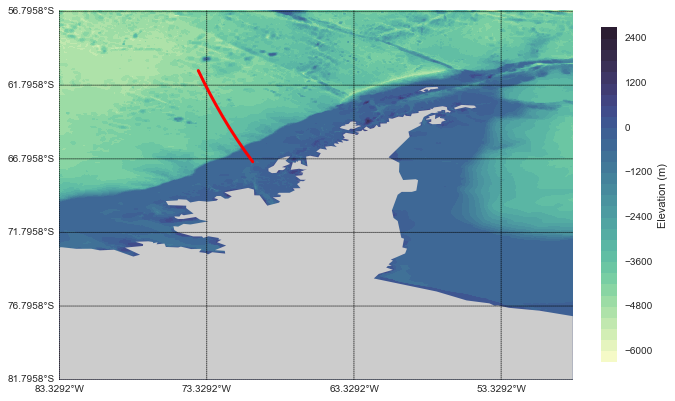

In [5]:
plt.figure(figsize=(10,10))
lat_max = np.max(lats); lat_min = np.min(lats); 
lon_min = np.min(lons) + 360; lon_max = np.max(lons) + 360
m = Basemap(projection='cyl',lon_0=210,resolution='l', llcrnrlat=lat_min,
              urcrnrlat=lat_max, llcrnrlon=lon_min, urcrnrlon=lon_max);
x, y = np.meshgrid(lons+360, lats);
cs = m.contourf(x, y, elev[:], 30, latlon=True, cmap=cmocean.cm.bathymetry)
plt.colorbar(label='Elevation (m)', fraction=0.03)
m.fillcontinents(color='0.8', lake_color='0.8');
parallels = np.arange(lat_min,lat_max,5);
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10);
meridians = np.arange(lon_min,lon_max,10.)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10);
m.drawgreatcircle(pt1[1] + 360, pt1[0], pt2[1] + 360, pt2[0], latlon=True, c='r', lw=3)

# Methods
The basic approach to this problem is simple.  We need to first generate a set of points along the line given in red and then find a way to query the bathymetry at those points.

To tackle the first portion of this we will use the function below which relies on pyproj.

In [6]:
'''
ptsarr:
Takes in pair of points, returns latlon points along great circle between them at 100m intervals

Input
-----
lat1, lon1, lat2, lon2 = lat/lon location of two points of interest (-90 < lat <90,  -180 < lon < 180)

Returns
-------
lonlats = list of lat/lon pairs
dist    = distance between each set of sucessive points

'''
def ptsarr(lat1, lon1, lat2, lon2):
    g = pyproj.Geod(ellps='WGS84')
    (az12, az21, dist) = g.inv(lon1, lat1, lon2, lat2)
    lonlats = g.npts(lon1, lat1, lon2, lat2, 1 + int(dist/100))
    lonlats.insert(0, (lon1, lat1))
    lonlats.append((lon2, lat2))
    return lonlats, dist/1000

We will now locate the bathymetry data closest to each point we established above.  We take advantage of the 1D lat/lon arrays for the bathymetry data we loaded earlier.  For every lat and longitude along our line, we take a difference between that point and the array of points on the bathymetric grid.  Minimizing this new array gives us the approximate location of our data point in the bathymetry grid.

In [7]:
'''
find_nearest:
Takes in an array and point, returns index of the closest location 
in the array to the point

Inputs
-----
arr   = array of values (i.e. latitude)
value = point of interest

Returns
-----
idx = integer index of location 

'''
def find_nearest(arr, value):
    idx = (np.abs(arr-value)).argmin()
    return idx


Now I combine the two functions above into the main method which takes in the two lat/lon points defining our profile and outputs the bathymetry information between them.  

In [11]:
'''
pts2elevprofile:
Takes two points and returns ocean depth at points between them

Input
-----
lat1, lon1, lat2, lon2 = lat/lon location of two points of interest (-90 < lat <90,  -180 < lon < 180)

Output
-----
1-D array of longitudes, 1D array of latitudes, 1D array of elevations
dist = distance between source and measruemetn 
'''
def pts2elevprofile(lat1, lon1, lat2, lon2):
    points, dist = ptsarr(lat1, lon1, lat2, lon2)
    elev_arr = []
    for locs in points:
        lon = locs[0]
        lat = locs[1]
        idx_lat  = find_nearest(lats, lat)
        idx_lon  = find_nearest(lons, lon)
        elev     = bath_dat['elevation'][idx_lat, idx_lon]
        elev_arr = np.append(elev_arr, elev)
    points = np.array(points)
    dist_arr    = dist / (len(elev_arr)-1) * np.ones(len(elev_arr))
    dist_arr[0] = 0

    return points[:,0], points[:, 1], elev_arr, dist_arr.cumsum()

Now lets implement the above function

In [12]:
lat, lon, z, dist = pts2elevprofile(pt1[0], pt1[1], pt2[0], pt2[1])

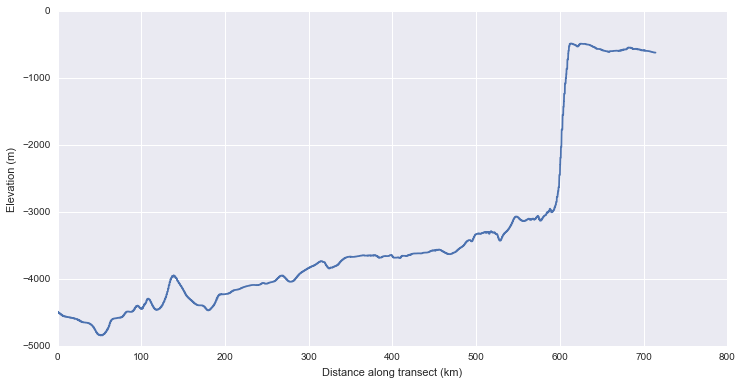

In [13]:
plt.figure(figsize=(12,6))
plt.plot(dist, z)
plt.xlabel('Distance along transect (km)')
plt.ylabel('Elevation (m)')

Simple enough!  For higher resolution instances you may need to use interpolation between neighboring grid points to arrive at a better guess for the elevation at each location.